# Plot the change in albedo on a map 
# for SINGLE cell runs
### Used for:
    - hom_single...
## Should work in the loop

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)

In [2]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)
X,Y = np.meshgrid(np.insert(data_grid.xu_i,0,0), data_grid.yu_j)

In [3]:
def run(refname, runname, country, single, year):
    ref=[]
    p=[]

    if country=='AU': name='Australia'
    if country=='EU': name='EU'
    if country=='AM': name='US'
    if country=='SH': name='China'
    if country=='VA': name='Vancouver'

    long_years=np.arange(54863, 55074, step=10)
    years=long_years-54983+2010
    #print(long_years)

    for y in long_years:
        ref.append(xr.open_dataset(
            climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
            "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
        p.append(xr.open_dataset(
            climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
                "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
    fig= plt.figure(figsize=(11.5,6))
    ax=fig.add_subplot(111)
    diff=p[np.where(years==year)[0][0]].data_vars['as'].mean(dim="Time")\
        -ref[np.where(years==year)[0][0]].data_vars['as'].mean(dim="Time")
    #plot=ax.pcolormesh(X_atl,Y_atl,change_to_Atl(diff), cmap='Greys_r', alpha=1)
    vmax=0.02
    if single: vmax=0.03
    plot=ax.pcolormesh(X_atl,Y_atl,change_to_Atl(diff), cmap='bwr_r', alpha=1, vmin=-vmax, vmax=vmax)
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c')
    m.drawcoastlines()
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cb=plt.colorbar(plot, cax=cax, ticks=[-0.02, 0, 0.02])#, label=r'$\Delta \alpha_S$')
    cb.ax.set_title(r'     ${\rm \Delta \alpha_S}$')
    cb.ax.tick_params(labelsize=18)

    #cb.ax.set_yticklabels(["-0.02", "0", "0.02"])
    #cb.ax.set_yticklabels(['%.3f' % float(tick) for tick in cb.ax.get_yticklabels()[:]])

    ax.text(0.1, 1.03, "`"+name+"'-case in "+str(year)+"   ("
                +r"$\overline{\Delta \alpha_S}=$"+ '%.5f' % area_mean_lon(diff)+')', transform=ax.transAxes)
    ax.set_xticks([X_atl[0,:][0],X_atl[0,:][len(X_atl[0,:])/4],X_atl[0,:][len(X_atl[0,:])/2],
                   X_atl[0,:][len(X_atl[0,:])/4*3], X_atl[0,:][-1]])
    ax.set_yticks([Y_atl[:,0][0],Y_atl[:,0][len(Y_atl[:,0])/4],Y_atl[:,0][len(Y_atl[:,0])/2],
                   Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    ax.tick_params(axis='both', which='major', labelsize=18)


    crosses_x=[]
    crosses_y=[]
    for i in range(0,16):
        for j in range(0,24):
            a=data_grid.xt_i[i].values-180
            crosses_x.append(a)
            crosses_y.append(data_grid.yt_j[j].values)
    ax.plot(crosses_x[:], crosses_y[:], '.', ms=1, color='black', alpha=0.7)

    if single:
        P, XXX=get_P(single, country, False, False, False)
        P_ind=np.where(P[-1]==np.max(P[-1]))
        # This is to ensure that all longitudes>180 are set to their (-XX) longitude
        x_atl_correct_order=-180 * np.floor((data_grid.xt_i)/180) + (data_grid.xt_i % 180) 
        ax.plot(( x_atl_correct_order)[P_ind[1][0]].values, data_grid.yt_j[P_ind[0][0]].values, 'X', ms=10, color='green')


    fig.tight_layout()
    print("Map_deltaAlbedo_"+runname+"_"+str(y)+".eps")
    plt.savefig("Map_deltaAlbedo_"+runname+"_"+str(y-54983+2010)+".eps",  bbox_inches='tight', format='eps')
    return diff

In [4]:
def area_mean_lon(x, lats=data_grid.yt_j, lon=data_grid.xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [5]:
def change_to_Atl(x, grid=data_grid):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
frlnd_atl=change_to_Atl(data_grid.frlnd[0])
X_atl=X-180
Y_atl=Y

In [6]:
def get_P(single, country, fut2250, SSP, opt):
    if single:
        P_folder="../data_preparation/PMIP/P_hum/"
        addendum=country.lower()+"_cell_"
        if country=="AU": P_folder+="txt_file_au_cell_each_yearJul13_13-24"
        elif country=="AM": P_folder+="txt_file_am_cell_each_yearJul13_13-24"
        elif country=="EU": P_folder+="txt_file_eu_cell_each_yearJul13_13-24"
        elif country=="SH": P_folder+="txt_file_sh_cell_each_yearJul13_13-24"
        elif country=="VA": P_folder+="txt_file_va_cell_each_yearJul13_13-24"
        else:
            print("wrong country")
    else:
        P_folder="../data_preparation/PMIP/P_hum/"
        P_folder+="txt_file_each_yearJul13_11-20"
        if SSP: 
            P_folder_fut="../data_preparation/future/"
            if opt=="1WB":
                P_folder_fut+="txt_file_each_yearJul14_16-12opt1"
            else:
                P_folder_fut+="txt_file_each_yearJul14_15-25opt2"
        addendum=""

    P=[]
    maxyear=2101
    if fut2250: maxyear=2251
    P_years=np.arange(1810,maxyear,step=1)
    P2010=np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year2010.dat")
    for y in P_years:
        if y>2010:
            if SSP:
                P.append(np.loadtxt(P_folder_fut+"/P_hum_"+addendum+"year"+str(y)+".dat"))
            else:
                P.append(1.02**(y-2010)*P2010)
        else:
            P.append(np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year"+str(y)+".dat"))
    return P, P_years

Map_deltaAlbedo_hom_singleAU_55073.eps
Map_deltaAlbedo_hom_singleAM_55073.eps
Map_deltaAlbedo_hom_singleEU_55073.eps
Map_deltaAlbedo_hom_singleSH_55073.eps
Map_deltaAlbedo_hom_singleVA_55073.eps


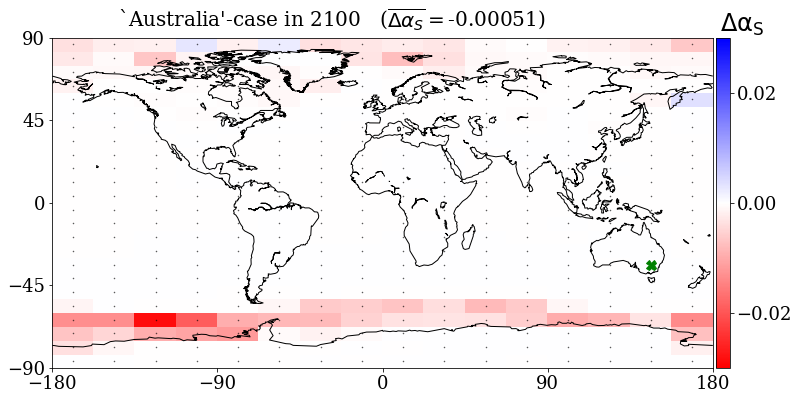

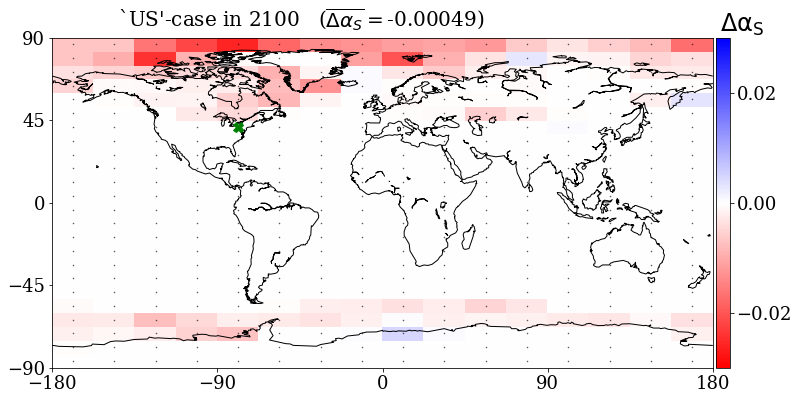

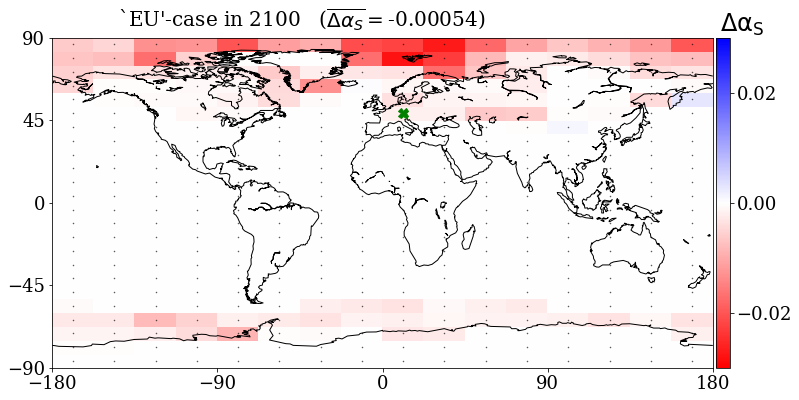

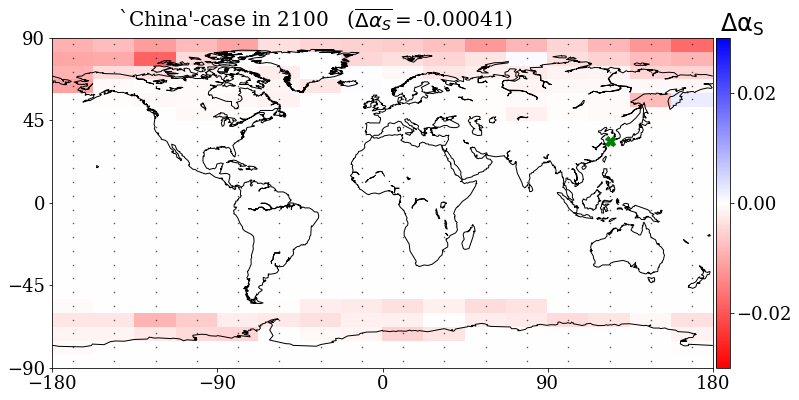

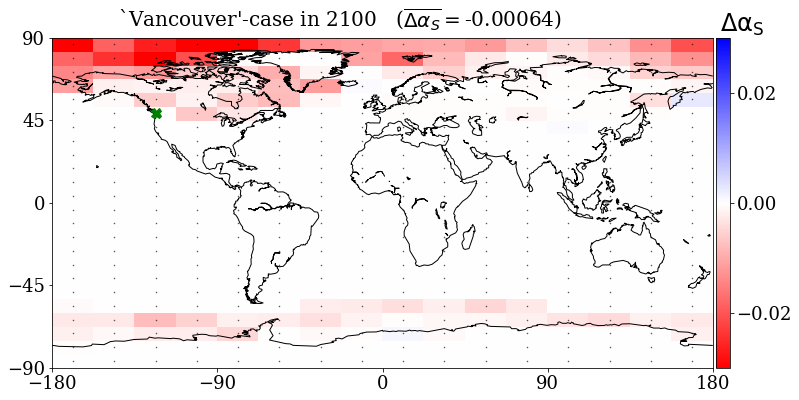

In [7]:
refname="hom_REF"
single=True
for country in ["AU", "AM", "EU", "SH", "VA"]:
    runname="hom_single"+country+""
    diff=run(refname, runname, country, single, 2100)